# Example 1: Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion Correction of functional images with FSL's MCFLIRT
2. TODO-CHANGE Image Resampling of anatomical image to a resolution of 3mmx3mmx3mm voxel size with AFNI's 3dresample
3. TODO-CHANGE Image Correction of motion corrected functional images to the resampled anatomical image with FSL's FLIRT
4. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm

**Note, that we will be using data for all 10 subjects from the ds000114 dataset in this and the following notebooks.** 

For every subject we have one anatomical T1w and 5 functional images. As a short recap, the image properties are:

In [17]:
!cd /data/ds000114/sub-01/ses-test/
!nib-ls [af]*/*.nii.gz

anat/sub-01_ses-test_T1w.nii.gz                            float32 [256, 156, 256]      1.00x1.30x1.00        sform
func/sub-01_ses-test_task-covertverbgeneration_bold.nii.gz  int16  [ 64,  64,  30, 173] 4.00x4.00x4.00x2.50   sform
func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz        int16  [ 64,  64,  30, 184] 4.00x4.00x4.00x2.50   sform
func/sub-01_ses-test_task-linebisection_bold.nii.gz         int16  [ 64,  64,  30, 238] 4.00x4.00x4.00x2.50   sform
func/sub-01_ses-test_task-overtverbgeneration_bold.nii.gz   int16  [ 64,  64,  30,  88] 4.00x4.00x4.00x5.00   sform
func/sub-01_ses-test_task-overtwordrepetition_bold.nii.gz   int16  [ 64,  64,  30,  76] 4.00x4.00x4.00x5.00   sform



**So, let's start!**

# Imports

First, let's import all modules we later will be needing.

In [18]:
%matplotlib inline
from os.path import join as opj
import os
from nipype.interfaces.fsl import MCFLIRT, FLIRT, ExtractROI, BET, FAST, ImageMaths
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. We will use one functional image for fingerfootlips task for two subjects.

In [4]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']

# list of session identifiers
task_list = ['fingerfootlips']

# Smoothing widths to apply
fwhm = [4, 8]

# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [5]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# BET - strip the anatomical image
stripper = Node(BET(), name='stripper')

# FAST - get WM segmentation
fast = Node(FAST(), name='fast')

# ImageMaths - binarize the segmentation
binarize = Node(ImageMaths(op_string='-nan -thr 0.5 -bin'),
                name='binarize')

pickindex = lambda x, i: x[i]

# FLIRT - coregister functional images to anatomical images
mean2anat = Node(FLIRT(), name='mean2anat')
mean2anat.inputs.dof = 6

# FLIRT - Now use bbr cost function to improve the transform
mean2anatbbr = Node(FLIRT(), name='mean2anatbbr')
mean2anatbbr.inputs.dof = 6
mean2anatbbr.inputs.cost = 'bbr'
mean2anatbbr.inputs.schedule = opj(os.getenv('FSLDIR'),
                                            'etc/flirtsch/bbr.sch')
# FLIRT - apply the transform
#coreg_step2 = Node(FLIRT(output_type='NIFTI',
#                         apply_xfm=True), name="coreg_step2")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('derivatives', 'fmriprep', '{subject_id}', 'anat', '{subject_id}_t1w_preproc.nii.gz')
func_file = opj('{subject_id}', 'ses-test', 'func',
                '{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
# Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_mcf.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
datasink.inputs.substitutions = substitutions

# Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [7]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (selectfiles, stripper, [('anat', 'in_file')]),
                 (stripper, fast, [('out_file', 'in_files')]),
                 (fast, binarize, [(('partial_volume_files', pickindex, 2), 'in_file')]),
                 
                 (mcflirt, mean2anat, [('mean_img', 'in_file')]),
                 (stripper, mean2anat, [('out_file', 'reference')]),

                 (mcflirt, mean2anatbbr, [('mean_img', 'in_file')]),
                 (binarize, mean2anatbbr, [('out_file', 'wm_seg')]),
                 (selectfiles, mean2anatbbr, [('anat', 'reference')]),
                 (mean2anat, mean2anatbbr, [('out_matrix_file', 'in_matrix_file')]),
                 
                 (mcflirt, smooth, [('out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (mean2anat, datasink, [('out_file', 'preproc.@coregmean')]),
                 (mean2anatbbr, datasink, [('out_matrix_file', 'preproc.@coregmatrix')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 ])

# Visualize the workflow

It always helps to visualize your workflow.

170809-02:33:33,196 workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.dot.png (graph2use=colored, simple_form=True).


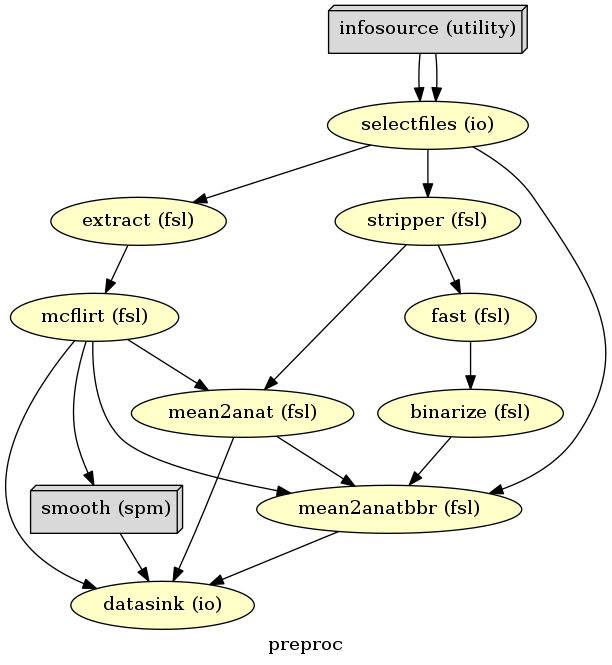

In [8]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

170809-02:33:33,905 workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.dot.png (graph2use=flat, simple_form=True).


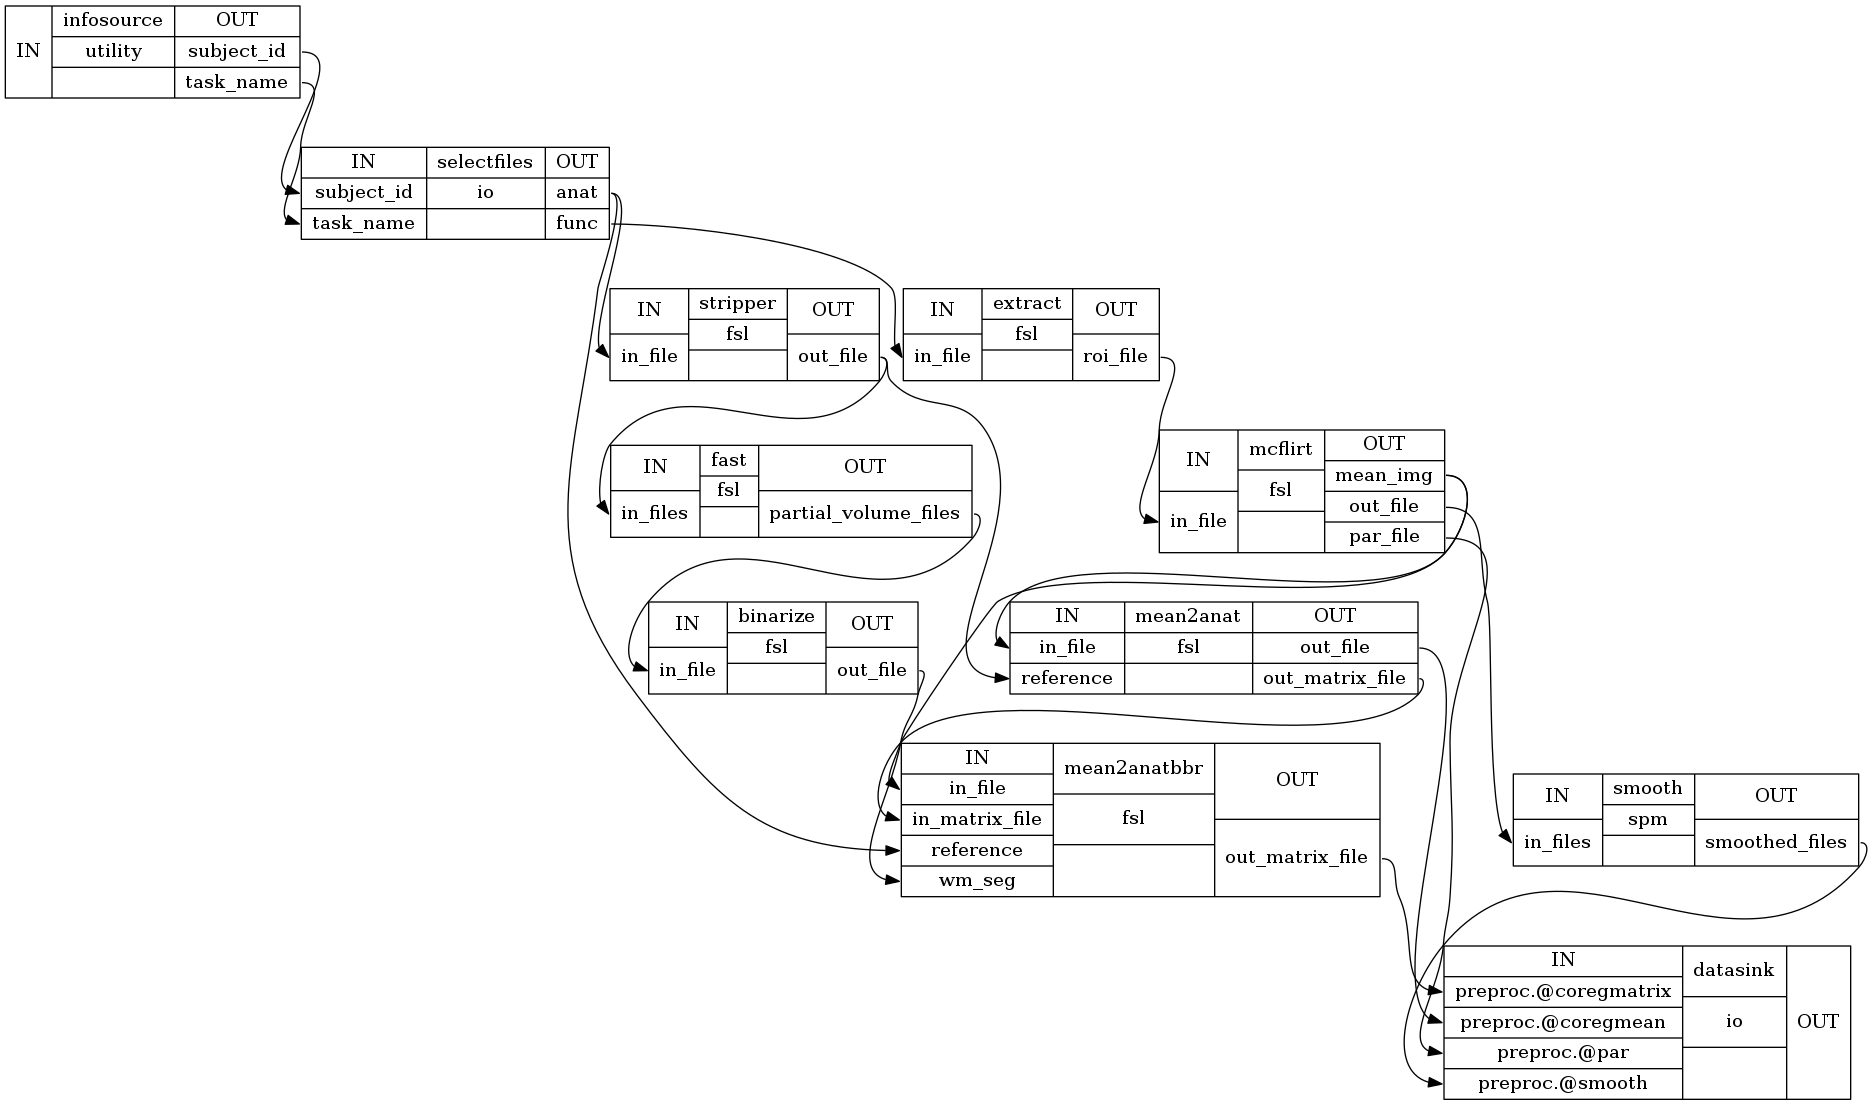

In [9]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

#  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. 

Note that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [10]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

170809-02:33:34,131 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
170809-02:33:34,442 workflow INFO:
	 Running in parallel.
170809-02:33:34,453 workflow INFO:
	 Executing: selectfiles.b9 ID: 0
170809-02:33:34,474 workflow INFO:
	 Executing: selectfiles.b8 ID: 12
170809-02:33:34,478 workflow INFO:
	 Executing node selectfiles.b9 in dir: /output/workingdir/preproc/_subject_id_sub-10_task_name_fingerfootlips/selectfiles
170809-02:33:34,538 workflow INFO:
	 Executing node selectfiles.b8 in dir: /output/workingdir/preproc/_subject_id_sub-09_task_name_fingerfootlips/selectfiles170809-02:33:34,533 workflow INFO:
	 Executing: selectfiles.b7 ID: 24

170809-02:33:34,633 workflow INFO:
	 Executing node selectfiles.b7 in dir: /output/workingdir/preproc/_subject_id_sub-08_task_name_fingerfootlips/selectfiles170809-02:33:34,629 workflow INFO:
	 Executing: selectfiles.b6 ID: 36

170809-02:33:34,728 workflow INFO:
	 Executing node selectfiles.b6 in dir: /output/workingd

# Inspect output

let's check the structure of the output folder, to see if we have everything we wanted to save.

In [11]:
!tree /output/datasink/preproc

/output/datasink/preproc
|-- sub-01
|   `-- task-fingerfootlips
|       |-- fwhm-4
|       |   `-- ssub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii
|       |-- fwhm-8
|       |   `-- ssub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii
|       |-- sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.par
|       |-- sub-01_ses-test_task-fingerfootlips_bold_roi_mean_flirt.mat
|       `-- sub-01_ses-test_task-fingerfootlips_bold_roi_mean_flirt.nii.gz
|-- sub-02
|   `-- task-fingerfootlips
|       |-- fwhm-4
|       |   `-- ssub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii
|       |-- fwhm-8
|       |   `-- ssub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii
|       |-- sub-02_ses-test_task-fingerfootlips_bold_roi_mcf.par
|       |-- sub-02_ses-test_task-fingerfootlips_bold_roi_mean_flirt.mat
|       `-- sub-02_ses-test_task-fingerfootlips_bold_roi_mean_flirt.nii.gz
|-- sub-03
|   `-- task-fingerfootlips
|       |-- fwhm-4
|       |   `-- ssub-03_ses-test_task-fingerfootlips_bold_r

# Visualize results

let's check the effect of the different smoothing kernels.

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


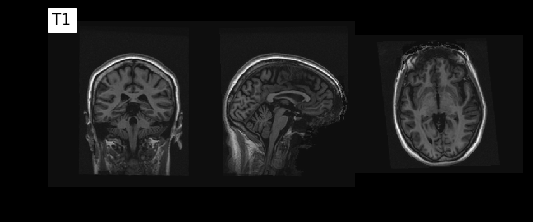

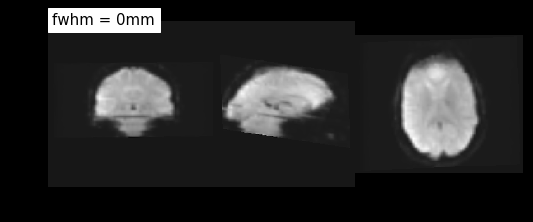

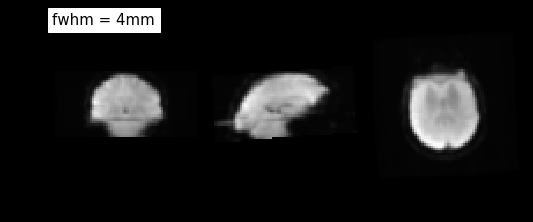

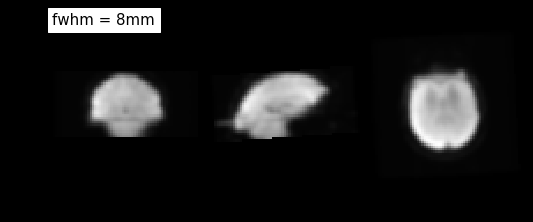

In [12]:
from nilearn import image, plotting
plotting.plot_epi(
    '/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz', title="T1",
    display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(
    '/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_ses-test_task-fingerfootlips_bold_roi_mean_flirt.nii.gz', title="fwhm = 0mm",
    display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

mean_img = image.mean_img('/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-4/ssub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii')
plotting.plot_epi(mean_img, title="fwhm = 4mm", display_mode='ortho',
                  annotate=False, draw_cross=False, cmap='gray')

mean_img = image.mean_img('/output/datasink/preproc/sub-01/task-fingerfootlips/fwhm-8/ssub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii')
plotting.plot_epi(mean_img, title="fwhm = 8mm", display_mode='ortho',
                  annotate=False, draw_cross=False, cmap='gray')

How do the motion parameters look like?

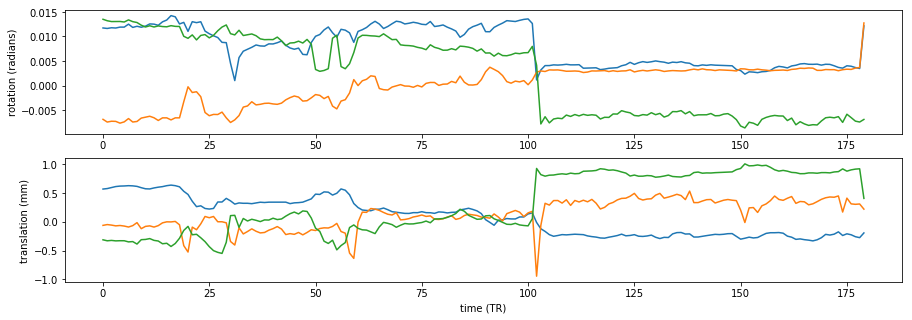

In [15]:
import numpy as np
import pylab as plt
par = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')